# PlantPal


**Method**

In this notebook, I train a convolutional neural network to identify houseplants

In particular, I use transfer learning with fine-tuning to achieve high accuracy while minimizing the amount of compute required to train the classifier.

In [4]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Training Labels

All labels for the images are encoded into the directory structure of this dataset. Just extract it into a pandas DataFrame:

In [42]:
input_path = '../data/data/'

image_df = pd.DataFrame({'path': list(Path(input_path).glob('**/*.jp*g'))})

image_df['plant'] = image_df['path'].map(lambda x: x.parent.stem)
image_df['data_split'] = image_df['path'].map(lambda x: x.parent.parent.stem)
image_df['path'] = image_df['path'].map(lambda x: str(x)) # convert the path back to a string

image_df.head()

,path,plant,data_split
0,../data/data/test/Aloe_Vera/Aloe_Vera_51.jpeg,Aloe_Vera,test
1,../data/data/test/Aloe_Vera/Aloe_Vera_113.jpeg,Aloe_Vera,test
2,../data/data/test/Aloe_Vera/Aloe_Vera_172.jpeg,Aloe_Vera,test
3,../data/data/test/Aloe_Vera/Aloe_Vera_67.jpeg,Aloe_Vera,test
4,../data/data/test/Aloe_Vera/Aloe_Vera_66.jpeg,Aloe_Vera,test


# Training Images

First, inspect the images:

In [43]:
import cv2

# read it in unchanged, to make sure we aren't losing any information
img = cv2.imread(image_df['path'][0], cv2.IMREAD_UNCHANGED)
np.shape(img)

# get the train-validation-test splits
image_df_train = image_df[image_df['data_split']=='train'].copy()
image_df_val = image_df[image_df['data_split']=='val'].copy()
image_df_test = image_df[image_df['data_split']=='test'].copy()

# Transfer Learning

In general, there are two types of transfer learning in the context of deep learning:

* via feature extraction
    * treating the network as an arbitrary feature extractor
    * essentially 'chop off' the network at our pre-specified layer (typically prior to the fully-connected layers when actual classification predictions are made), then propagate some input through this 'shortened' network, get the output array, flatten it, and use that as the feature vector for the original input in another classification algorithm
    * the two most common machine learning models for transfer learning via feature extraction are logistic regression and linear SVM:
        * CNN's are non-linear models capable of learning non-linear features — we are assuming that the features learned by the CNN are already robust and discriminative
        * feature vectors tend to be very large and have high dimensionality - we therefore need a fast model that can be trained on top of the features
        * linear models tend to be very fast to train
* via fine-tuning
    * removing the fully-connected layers of an existing network, placing a new set of fully-connected layers on top of the network, and then fine-tuning these weights (and optionally previous layers) to recognize the new object classes
    * this technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on

In this notebook, I will use the fine-tuning method, but an example of using the feature extraction method can be found [here](https://www.kaggle.com/kmader/damage-classification-with-resnet-features).

In [44]:
import tensorflow as tf
tf.__version__

'2.0.0'

# Image Preprocessing

We could use `tf.keras.preprocessing` to load the images, but it has 3 downsides:

1. it's slow
2. it lacks fine-grained control
3. it's not well integrated with the rest of TensorFlow

Alternatively, we could use `tf.data.Dataset`. From the documentation:

> The `tf.data` API enables you to build complex input pipelines from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training.

This API allows the user to only call the data (and apply transformations, etc.) when the data is actually needed, instead of keeping all the images in RAM indefinitely.

I'll use the `tf.data.Dataset` API.

Get the paths and labels:

In [45]:
class_names = image_df['plant'].unique()
no_classes = len(class_names)

In [46]:
# paths
train_path = image_df_train['path'].copy().values
val_path = image_df_val['path'].copy().values
test_path = image_df_test['path'].copy().values

# labels
train_labels = np.zeros(len(image_df_train), dtype=np.int8)
val_labels = np.zeros(len(image_df_val), dtype=np.int8)
test_labels = np.zeros(len(image_df_test), dtype=np.int8)

for i in range(len(class_names)):
    train_labels[image_df_train['plant'].values==class_names[i]] = i
    val_labels[image_df_val['plant'].values==class_names[i]] = i
    test_labels[image_df_test['plant'].values==class_names[i]] = i

Merge into a Dataset:

In [47]:
train_ds = tf.data.Dataset.from_tensor_slices((train_path, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_path, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_path, test_labels))

# note that the `numpy()` function is required to grab the actual values from the Dataset
for path, label in train_ds.take(5):
    print("path  : ", path.numpy().decode('utf-8'))
    print("label : ", label.numpy())

path  :  ../data/data/train/Aloe_Vera/Aloe_Vera_191.jpeg
label :  0
path  :  ../data/data/train/Aloe_Vera/Aloe_Vera_4.jpeg
label :  0
path  :  ../data/data/train/Aloe_Vera/Aloe_Vera_129.jpeg
label :  0
path  :  ../data/data/train/Aloe_Vera/Aloe_Vera_200.jpeg
label :  0
path  :  ../data/data/train/Aloe_Vera/Aloe_Vera_10.jpeg
label :  0


Define functions to get the actual images from the paths and do simple transformations. Then map these onto the Dataset:

Note that this is where the most issues were experienced. The code here, which seems simple enough, will fail with an opaque error message even if the slightest thing is done incorrectly. Take note of the comments carefully...

In [48]:
# this function wraps `cv2.imread` - we treat it as a 'standalone' function, and therefore can use
# eager execution (i.e. the use of `numpy()`) to get a string of the path.
# note that no tensorflow functions are used here
def cv2_imread(path, label):
    # read in the image, getting the string of the path via eager execution
    img = cv2.imread(path.numpy().decode('utf-8'), cv2.IMREAD_UNCHANGED)
    # change from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, label

# this function assumes that the image has been read in, and does some transformations on it
# note that only tensorflow functions are used here
def tf_cleanup(img, label):
    # convert to Tensor
    img = tf.convert_to_tensor(img)
    # unclear why, but the jpeg is read in as uint16 - convert to uint8
    img = tf.dtypes.cast(img, tf.uint8)
    # set the shape of the Tensor
    img.set_shape((128, 128, 3))
    # convert to float32, scaling from uint8 (0-255) to float32 (0-1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image
    img = tf.image.resize(img, [128, 128])
    # convert the labels into a Tensor and set the shape
    label = tf.convert_to_tensor(label)
    label.set_shape(())
    return img, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

# map the cv2 wrapper function using `tf.py_function`
train_ds = train_ds.map(lambda path, label: tuple(tf.py_function(cv2_imread, [path, label], [tf.uint16, label.dtype])),
                        num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda path, label: tuple(tf.py_function(cv2_imread, [path, label], [tf.uint16, label.dtype])),
                    num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda path, label: tuple(tf.py_function(cv2_imread, [path, label], [tf.uint16, label.dtype])),
                      num_parallel_calls=AUTOTUNE)

# map the TensorFlow transformation function - no need to wrap
train_ds = train_ds.map(tf_cleanup, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(tf_cleanup, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(tf_cleanup, num_parallel_calls=AUTOTUNE)

Image augmentation:

Augment the training and validation data by applying random flips and rotations.

In [49]:
def rotate_augmentation(img, label):
    # rotate 0, 90, 180, or 270 degrees with 25% probability for each
    img = tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32, seed=1111))
    return img, label

def flip_augmentation(img, label):
    # flip with 50% probability for left-right and up-down
    img = tf.image.random_flip_left_right(img, seed=2222)
    img = tf.image.random_flip_up_down(img, seed=3333)
    return img, label

# map the augmentations, creating a new Dataset
augmented_train_ds = train_ds.map(rotate_augmentation, num_parallel_calls=AUTOTUNE)
augmented_train_ds = augmented_train_ds.map(flip_augmentation, num_parallel_calls=AUTOTUNE)

augmented_val_ds = val_ds.map(rotate_augmentation, num_parallel_calls=AUTOTUNE)
augmented_val_ds = augmented_val_ds.map(flip_augmentation, num_parallel_calls=AUTOTUNE)

# concatenate the augmented and original datasets
train_ds = train_ds.concatenate(augmented_train_ds)
val_ds = val_ds.concatenate(augmented_val_ds)

Shuffle:

Note that the buffer size for shuffling defines how random the Dataset becomes - a buffer size that's equal to the number of instances will result in a uniform shuffling over the entire Dataset, and a buffer size equal to 1 will result in no shuffling. Since the data is currently ordered by label, we need make sure we do a nice full shuffle over the entire dataset:

In [50]:
# double the number of samples in the training and validation splits, due to our augmentation procedure
n_train = len(train_labels)*2
n_val = len(val_labels)*2
n_test = len(test_labels)

# shuffle over the entire dataset, seeding the shuffling for reproducible results
train_ds = train_ds.shuffle(n_train, seed=2019, reshuffle_each_iteration=True)
val_ds = val_ds.shuffle(n_val, seed=2019, reshuffle_each_iteration=True)
test_ds = test_ds.shuffle(n_test, seed=2019, reshuffle_each_iteration=True)

Check to make sure everything was read in correctly:

In [51]:
n_train_check = 0
for element in train_ds:
    n_train_check = n_train_check + 1
print(n_train_check)

476


Batch the data. A batch size of 32 seems like a common starting point, and using powers of 2 is preferred when using a GPU.

In [52]:
BATCH_SIZE = 4

train_batches_ds = train_ds.batch(BATCH_SIZE)
val_batches_ds = val_ds.batch(BATCH_SIZE)
test_batches_ds = test_ds.batch(BATCH_SIZE)

# The Model

Let's use VGG16 for the base of the model:

In [53]:
IMG_SHAPE = (128, 128, 3)

# create the base model from the pre-trained model VGG16
# note that, if using a Kaggle server, internet has to be turned on
pretrained_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet')

# freeze the convolutional base
pretrained_model.trainable = False

Look at the model architecture:

In [54]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [55]:
# set the initializers with a seed for reproducible behaviour
prediction_layer = tf.keras.layers.Dense(1,
                                         kernel_initializer=tf.keras.initializers.GlorotUniform(seed=1992),
                                         bias_initializer=tf.keras.initializers.GlorotUniform(seed=1992))

Now stack all the components using a `tf.keras.Sequential` model:

In [56]:
model = tf.keras.Sequential([pretrained_model,
                             global_average_layer,
                             prediction_layer,
                             tf.keras.layers.Dense(no_classes, activation='softmax')])

Compile the model. Since there are two classes, use a binary cross-entropy loss:

In [57]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 4         
Total params: 14,715,205
Trainable params: 517
Non-trainable params: 14,714,688
_________________________________________________________________


Train the model:

In [59]:
initial_epochs = 20
steps_per_epoch = n_train//BATCH_SIZE
validation_steps = 20

loss0, accuracy0 = model.evaluate(val_batches_ds, steps=validation_steps)

20/20 [==============================] - 10s 523ms/step - loss: 1.2253 - accuracy: 0.5000


In [ ]:
history = model.fit(train_batches_ds,
                    epochs=initial_epochs,
                    validation_data=val_batches_ds,
                    validation_steps=validation_steps)

Epoch 1/20
119/119 [==============================] - 67s 561ms/step - loss: 0.9756 - accuracy: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
119/119 [==============================] - 66s 556ms/step - loss: 0.7344 - accuracy: 0.5000 - val_loss: 0.7109 - val_accuracy: 0.5000
Epoch 3/20
119/119 [==============================] - 65s 542ms/step - loss: 0.7120 - accuracy: 0.5000 - val_loss: 0.7194 - val_accuracy: 0.5000
Epoch 4/20
119/119 [==============================] - 66s 551ms/step - loss: 0.7094 - accuracy: 0.5000 - val_loss: 0.7086 - val_accuracy: 0.5000
Epoch 5/20
119/119 [==============================] - 65s 542ms/step - loss: 0.7070 - accuracy: 0.5000 - val_loss: 0.7117 - val_accuracy: 0.5000
Epoch 6/20
119/119 [==============================] - 63s 527ms/step - loss: 0.7057 - accuracy: 0.5000 - val_loss: 0.7091 - val_accuracy: 0.5000
Epoch 7/20
119/119 [==============================] - 63s 531ms/step - loss: 0.7052 - accuracy: 0.5000 - val_loss: 0.7094 

Learning curves:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, initial_epochs+1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')

plt.show()

Some notes from the TensorFlow tutorial on transfer learning:

> Now fine-tune the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset. This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned. Only a small number of top layers of the pre-trained model should be fine-tuned. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features which generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [31]:
# unfreeze the layers
pretrained_model.trainable = True

# let's take a look to see how many layers are in the base model
print("Number of layers in the pre-trained model: ", len(pretrained_model.layers))

Number of layers in the pre-trained model:  19


In [32]:
# fine-tune from this layer onwards
fine_tune_at = 15

# freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable =  False

Recompile the model using a lower training rate:

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 7,079,937
Non-trainable params: 7,635,264
_________________________________________________________________


In [34]:
len(model.trainable_variables)

8

Continue training:

In [35]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1]+1,
                         validation_data=val_batches_ds,
                         validation_steps=validation_steps)

Epoch 16/40
119/119 [==============================] - 158s 1s/step - loss: 0.1956 - accuracy: 0.9223 - val_loss: 0.2724 - val_accuracy: 0.9625
Epoch 17/40
119/119 [==============================] - 237s 2s/step - loss: 0.0435 - accuracy: 0.9853 - val_loss: 0.0405 - val_accuracy: 0.9750
Epoch 18/40
119/119 [==============================] - 157s 1s/step - loss: 0.0290 - accuracy: 0.9937 - val_loss: 0.2212 - val_accuracy: 0.9750
Epoch 19/40
119/119 [==============================] - 144s 1s/step - loss: 0.0149 - accuracy: 0.9916 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 20/40
119/119 [==============================] - 250s 2s/step - loss: 0.0052 - accuracy: 0.9979 - val_loss: 0.2231 - val_accuracy: 0.9875
Epoch 21/40
119/119 [==============================] - 177s 1s/step - loss: 0.0065 - accuracy: 0.9958 - val_loss: 0.2223 - val_accuracy: 0.9750
Epoch 22/40
119/119 [==============================] - 181s 2s/step - loss: 0.0093 - accuracy: 0.9979 - val_loss: 0.3073 - val_accuracy:

Updated training curves:

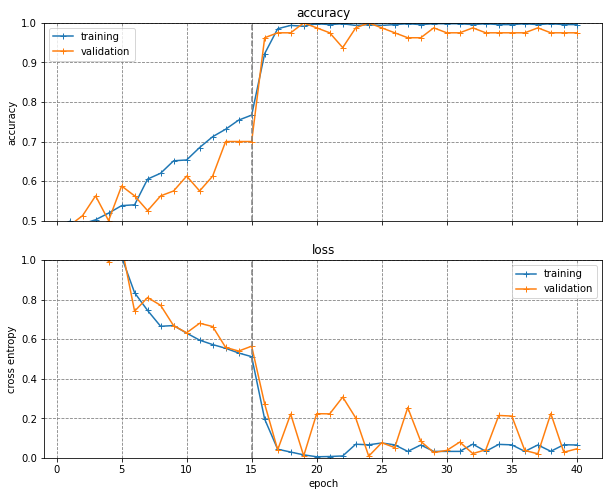

In [77]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), sharex=True)

x_plot = np.arange(1, total_epochs+1)

ax[0].plot(x_plot, acc, '+-', label='training')
ax[0].plot(x_plot, val_acc, '+-', label='validation')
ax[0].legend()
ax[0].set_ylabel('accuracy')
ax[0].set_ylim(0.5, 1)
ax[0].grid(ls='--', c='C7')
ax[0].set_title('accuracy')
ax[0].axvline(initial_epochs, c='C7', ls='--')

ax[1].plot(x_plot, loss, '+-', label='training')
ax[1].plot(x_plot, val_loss, '+-', label='validation')
ax[1].legend()
ax[1].set_ylabel('cross entropy')
ax[1].set_ylim(0, 1)
ax[1].grid(ls='--', c='C7')
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')
ax[1].axvline(initial_epochs, c='C7', ls='--')

plt.show()

Now we can make a prediction on the full validation and test sets:

In [ ]:
val_loss, val_accuracy = model.evaluate(val_batches_ds)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_batches_ds)

Note that in the study associated with this dataset, the best performance achieved was:

* convolutional neural network + data augmentation + 50% dropout in the fully connected layer + Adam optimizer:
    * validation accuracy: 98.06%
    * test accuracy (balanced): 97.29%

In [36]:
model.save('./TF_models/binary_mod_1.0.hdf5')

# Put model to work

In [ ]:
file = './2_examples/Aloe_Vera/Aloe_Vera_1.jpeg'
image_df = pd.DataFrame({'path': list(file)})

image_df['plant'] = image_df['path'].map(lambda x: x.parent.stem)
image_df['data_split'] = image_df['path'].map(lambda x: x.parent.parent.stem)
image_df['path'] = image_df['path'].map(lambda x: str(x)) # convert the path back to a string

image_df.head()

In [49]:
input_batches_ds

<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>

In [55]:
def predict_plant:
    input_ds = tf.data.Dataset.from_tensor_slices(([file], [1]))

    # map the cv2 wrapper function using `tf.py_function`
    input_ds = input_ds.map(lambda path, label: tuple(tf.py_function(cv2_imread, [path, label], [tf.uint16, label.dtype])),
                          num_parallel_calls=AUTOTUNE)

    # map the TensorFlow transformation function - no need to wrap
    input_ds = input_ds.map(tf_cleanup, num_parallel_calls=AUTOTUNE)

    # check that the image was read in correctly
    for image, label in input_ds.take(1):
        print("image shape : ", image.numpy().shape)
        print("label       : ", label.numpy())

    input_batches_ds = input_ds.batch(1)

    result = model.predict(input_batches_ds)

    if result[0][0] < 0.5:
        return 'Fiddle Leaf Fig'
    else:
        return 'Aloe Vera'

image shape :  (128, 128, 3)
label       :  1


array([-1.3296574], dtype=float32)

In [65]:
model.save_weights('./models/binary_prelimmod_1.0_weights.h5')
model.save('./models/binary_prelimmod_1.0.h5')